In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras import layers
from keras import models
from keras.optimizers import Adam
from skimage.transform import resize
from skimage.color import gray2rgb
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [2]:
# Load the dataset
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

train_labels = train_df['label'].values
test_labels = test_df['label'].values

# Remap labels to be in the range [0, 23]
train_labels = train_labels - 1  # Subtract 1 from each label
test_labels = test_labels - 1    # Subtract 1 from each label

# Correct labels with value -1 by mapping to a valid label
train_labels[train_labels == -1] = 8  
test_labels[test_labels == -1] = 8    

# Normalize and reshape the data
train_images = (train_df.iloc[:, 1:].values / 255.0).reshape(-1, 28, 28, 1)
test_images = (test_df.iloc[:, 1:].values / 255.0).reshape(-1, 28, 28, 1)

In [3]:
unique_labels = np.unique(train_labels)
print(unique_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

In [5]:
train_datagen.fit(train_images)

In [6]:
# Resize input images to (48, 48, 3) using skimage's resize function and convert to RGB
train_images_resized = np.array([gray2rgb(resize(np.squeeze(img, axis=-1), (48, 48), mode='reflect')) for img in train_images])
test_images_resized = np.array([gray2rgb(resize(np.squeeze(img, axis=-1), (48, 48), mode='reflect')) for img in test_images])

In [7]:
print("Shape of train_images_resized:", train_images_resized.shape)
print("Shape of test_images_resized:", test_images_resized.shape)

Shape of train_images_resized: (27455, 48, 48, 3)
Shape of test_images_resized: (7172, 48, 48, 3)


In [8]:
# Load the pretrained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [9]:
model = models.Sequential()
model.add(base_model)
# Replace Flatten with GlobalAveragePooling2D
model.add(layers.GlobalAveragePooling2D())  
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
# 24 classes for A-Z
model.add(layers.Dense(24, activation='softmax'))  

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Learning Rate Schedule
def lr_schedule(epoch):
    if epoch < 5:
        # Keep the initial learning rate for the first few epochs
        return 1e-5  
    else:
        # Reduce the learning rate after some epochs
        return 1e-6  

lr_scheduler = LearningRateScheduler(lr_schedule)

In [12]:
# Implement Early Stopping based on validation accuracy
early_stopping = EarlyStopping(
    # Monitor validation accuracy
    monitor='val_accuracy',    
    # Number of epochs with no improvement after which training will stop
    patience=5,                
    # Print early stopping updates
    verbose=1,                 
    # Restore the best model weights when early stopping is triggered
    restore_best_weights=True  
)

In [13]:
# Implement Model Checkpoints to save the best model based on 
# validation accuracy
checkpoint_path = "resnet50_model.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    verbose=1
)

In [14]:
# Train the model, starting from the last checkpoint, 
# Early Stopping monitoring validation accuracy
history = model.fit(
    train_datagen.flow(train_images_resized, train_labels, batch_size=128),
    steps_per_epoch=len(train_images_resized) / 128,
    epochs=20,
    validation_data=(test_images_resized, test_labels),
    callbacks=[lr_scheduler, model_checkpoint, early_stopping] 
)

Epoch 1/20
215/214 [==============================] - ETA: -3s - loss: 3.4844 - accuracy: 0.1393
Epoch 1: val_accuracy improved from -inf to 0.06079, saving model to resnet50_model.h5


c:\Users\Xuan Min\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


214/214 [==============================] - 1729s 8s/step - loss: 3.4844 - accuracy: 0.1393 - val_loss: 364.4904 - val_accuracy: 0.0608 - lr: 1.0000e-05
Epoch 2/20
215/214 [==============================] - ETA: -3s - loss: 2.0240 - accuracy: 0.4174
Epoch 2: val_accuracy did not improve from 0.06079
214/214 [==============================] - 1613s 8s/step - loss: 2.0240 - accuracy: 0.4174 - val_loss: 713.2050 - val_accuracy: 0.0608 - lr: 1.0000e-05
Epoch 3/20
215/214 [==============================] - ETA: -3s - loss: 1.2032 - accuracy: 0.6567
Epoch 3: val_accuracy improved from 0.06079 to 0.11210, saving model to resnet50_model.h5
214/214 [==============================] - 1479s 7s/step - loss: 1.2032 - accuracy: 0.6567 - val_loss: 60.1576 - val_accuracy: 0.1121 - lr: 1.0000e-05
Epoch 4/20
215/214 [==============================] - ETA: -3s - loss: 0.6654 - accuracy: 0.8104
Epoch 4: val_accuracy did not improve from 0.11210
214/214 [==============================] - 1437s 7s/step - los

In [15]:
# Resume training from the last checkpoint
model.load_weights(checkpoint_path)

In [16]:
# Train the model, starting from the last checkpoint, 
# Early Stopping monitoring validation accuracy
history = model.fit(
    train_datagen.flow(train_images_resized, train_labels, batch_size=128),
    steps_per_epoch=len(train_images_resized) / 128,
    epochs=30,
    validation_data=(test_images_resized, test_labels),
    callbacks=[lr_scheduler, model_checkpoint, early_stopping] 
)

Epoch 1/30
215/214 [==============================] - ETA: -4s - loss: 0.0769 - accuracy: 0.9785
Epoch 1: val_accuracy improved from 0.98689 to 0.98926, saving model to resnet50_model.h5
214/214 [==============================] - 1762s 8s/step - loss: 0.0769 - accuracy: 0.9785 - val_loss: 0.0323 - val_accuracy: 0.9893 - lr: 1.0000e-05
Epoch 2/30
215/214 [==============================] - ETA: -3s - loss: 0.0483 - accuracy: 0.9871
Epoch 2: val_accuracy improved from 0.98926 to 0.99554, saving model to resnet50_model.h5
214/214 [==============================] - 1646s 8s/step - loss: 0.0483 - accuracy: 0.9871 - val_loss: 0.0215 - val_accuracy: 0.9955 - lr: 1.0000e-05
Epoch 3/30
215/214 [==============================] - ETA: -3s - loss: 0.0327 - accuracy: 0.9906
Epoch 3: val_accuracy did not improve from 0.99554
214/214 [==============================] - 1577s 7s/step - loss: 0.0327 - accuracy: 0.9906 - val_loss: 0.0201 - val_accuracy: 0.9946 - lr: 1.0000e-05
Epoch 4/30
215/214 [========

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                6168      
                                                                 
Total params: 24118424 (92.00 MB)
Trainable params: 24065304 (91.80 MB)
Non-trainable params: 53120 (207.50 KB)
__________

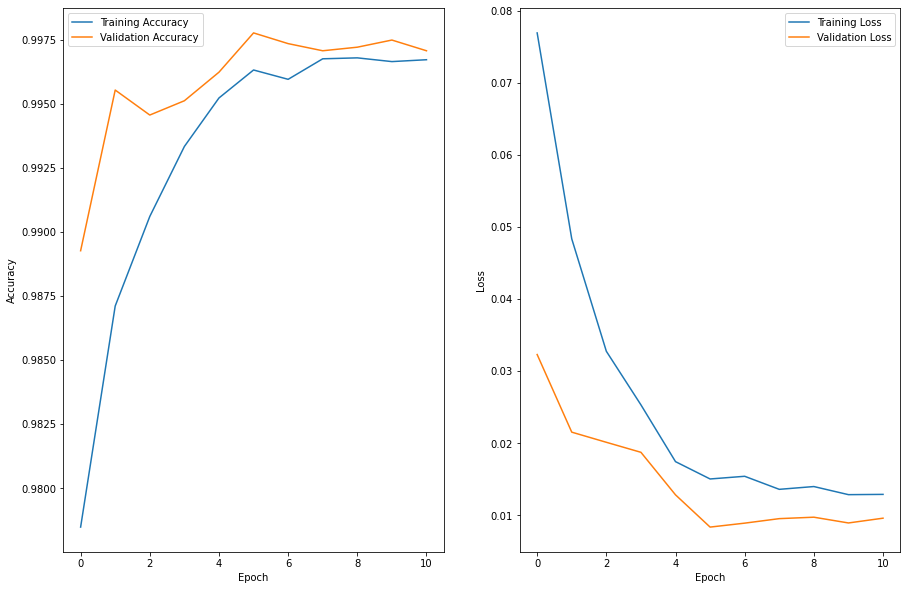

In [19]:
# Graph plot comparing Training Accuracy, Validation Accuracy, Loss, 
# and Validation Loss
plt.figure(figsize=(15, 10))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [20]:
# Make predictions on the test dataset using the trained model
test_predictions = model.predict(test_images_resized)
test_predictions_labels = np.argmax(test_predictions, axis=1)

# Print images that were recognized correctly and those that were not
for i in range(len(test_images_resized)):
    if test_predictions_labels[i] == test_labels[i]:
        print(f"Image {i + 1}: Recognized correctly as label {test_labels[i]}")
    else:
        print(f"Image {i + 1}: Not recognized correctly. Predicted label: {test_predictions_labels[i]}, True label: {test_labels[i]}")

225/225 [==============================] - 50s 212ms/step
Image 1: Recognized correctly as label 5
Image 2: Recognized correctly as label 4
Image 3: Recognized correctly as label 9
Image 4: Recognized correctly as label 8
Image 5: Recognized correctly as label 2
Image 6: Recognized correctly as label 20
Image 7: Recognized correctly as label 9
Image 8: Recognized correctly as label 13
Image 9: Recognized correctly as label 2
Image 10: Recognized correctly as label 6
Image 11: Recognized correctly as label 7
Image 12: Recognized correctly as label 7
Image 13: Recognized correctly as label 20
Image 14: Recognized correctly as label 11
Image 15: Recognized correctly as label 6
Image 16: Recognized correctly as label 3
Image 17: Recognized correctly as label 21
Image 18: Recognized correctly as label 8
Image 19: Recognized correctly as label 6
Image 20: Recognized correctly as label 6
Image 21: Recognized correctly as label 1
Image 22: Recognized correctly as label 8
Image 23: Recognized c

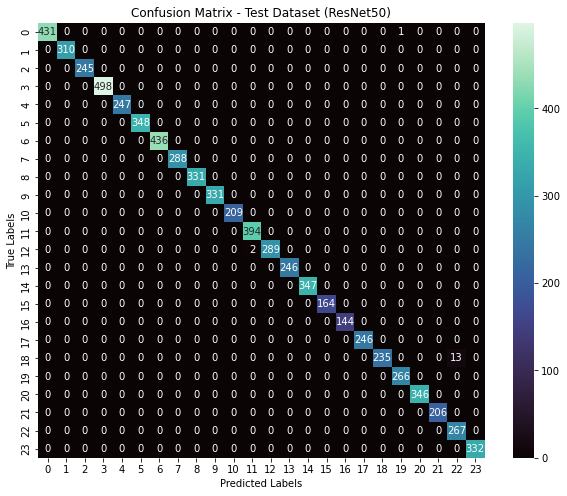

In [21]:
# Confusion Matrix for the test dataset
cm_test = confusion_matrix(test_labels, test_predictions_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap=sns.color_palette("mako", as_cmap=True))
plt.title('Confusion Matrix - Test Dataset (ResNet50)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [22]:
# Find misclassified samples
misclassified_samples = []
for i in range(len(test_labels)):
    if test_labels[i] != test_predictions_labels[i]:
        misclassified_samples.append(i)

# Print the indices of misclassified samples
print("Misclassified Samples (Index):", misclassified_samples)

Misclassified Samples (Index): [296, 1281, 1811, 2168, 2277, 2279, 4112, 4308, 4854, 5313, 5506, 6144, 6209, 6329, 6336, 6441]


In [23]:
# Calculate and print the loss, accuracy, precision, recall, and F1 score for ResNet50
loss_ResNet50, accuracy_ResNet50 = model.evaluate(test_images_resized, test_labels, verbose=0)
classification_report_output_ResNet50 = classification_report(test_labels, test_predictions_labels)
classification_lines_ResNet50 = classification_report_output_ResNet50.split('\n')[2:-5]
precision_ResNet50 = []
recall_ResNet50 = []
for line in classification_lines_ResNet50:
    values = line.split()
    precision_ResNet50.append(values[1])
    recall_ResNet50.append(values[2])
f1_ResNet50 = f1_score(test_labels, test_predictions_labels, average='weighted')

print("ResNet50 Test Loss:", loss_ResNet50)
print("ResNet50 Test Accuracy:", accuracy_ResNet50)
print("ResNet50 Precision:", ', '.join(precision_ResNet50))
print("ResNet50 Recall:", ', '.join(recall_ResNet50))
print("ResNet50 F1 Score:", f1_ResNet50)

ResNet50 Test Loss: 0.008330347016453743
ResNet50 Test Accuracy: 0.9977691173553467
ResNet50 Precision: 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.99, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.95, 1.00
ResNet50 Recall: 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.99, 1.00, 1.00, 1.00, 1.00, 1.00, 0.95, 1.00, 1.00, 1.00, 1.00, 1.00
ResNet50 F1 Score: 0.9977661702199949
